In [90]:
import joblib
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from sklearn.feature_extraction.text import CountVectorizer

%run procedural_stop_words.py

from plotnine import ggplot, aes, geoms, theme, ggtitle, ylim, xlim, ylab
from plotnine import element_blank, element_line, element_text, scales, annotate

# R package import 
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from statsmodels.stats.multitest import fdrcorrection

R = ro.r
pandas2ri.activate()

quanteda = importr('quanteda')
textstat = importr('quanteda.textstats')

token = R['tokens']
dfm = R['dfm']

grouper = R['dfm_group']
keyness = R['textstat_keyness']

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')
all_df = all_df.loc[all_df.party_y != 'I']

In [49]:
def run_jensen_corr(year,topic,binary=True):
    
    # subset year and topic
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    
    if len(sub_df) > 0:
        
        # get names of speakers and party
        features = sub_df.groupby('speaker',as_index=False).party_y.first()

        
        # Rpy2 corpus DTM setup
        tokens = token(sub_df['speech_processed'])
        DFM = dfm(tokens)
        grouped = grouper(DFM,groups=sub_df['party_y'])
        
        # Keyness Chi-Square Tests
        Keyness_DF = keyness(grouped,target='R',measure='chi2')
        
        # filter top 500 chi-square values and FDR correct p-values
        Keyness_DF['abs_chi2'] = Keyness_DF.chi2.abs()
        Keyness_DF = Keyness_DF.sort_values(by='abs_chi2',ascending=False).head(500)
        Keyness_DF['FDR'] = fdrcorrection(Keyness_DF['p'])[0]
        
        # words to remove from correlation analysis
        vocabulary = list(Keyness_DF.loc[Keyness_DF.FDR].feature.values)
        
        if len(vocabulary) == 0:
            return None
        
        # count terms by speech (min df = 5 for chi-sq)
        vectorizer = CountVectorizer(vocabulary=vocabulary,binary=binary)
        DTM = vectorizer.fit_transform(sub_df.speech_processed)
        DTM = pd.DataFrame(DTM.toarray())

        terms = vectorizer.get_feature_names() # vocabulary
        
        # sum term occurance by speaker and merge with party
        DTM['speaker'] = list(sub_df['speaker'])
        DTM = (DTM
               .groupby('speaker',as_index=False)
               .sum()
               .merge(features,on='speaker',how='left')
               .drop('speaker',1)
              )
        
        # party labesl for correlation
        party_list = [1 if _ == 'R' else -1 for _ in DTM['party_y']]
        
        # remove non-significant tokens from DTM
        DTM = DTM.drop('party_y',1).to_numpy()
        
        # mean center scale 0,1
        DTM = np.apply_along_axis(lambda x: (x - np.mean(x))/np.std(x),0,DTM)

        # correlations pairwise
        corrs = np.apply_along_axis(lambda x: np.corrcoef(x,party_list)[0,1],0,DTM)
        
        corr_df = pd.DataFrame({
            "term":terms,
            "correlation":corrs,
            'SE':np.sqrt((1-(corrs)**2)/len(DTM))
        }).dropna()

        partisanship = corr_df.correlation.mean()
        polarization = corr_df.correlation.abs().mean()
        
        return {"results":{"year":year,
                            "topic":topic,
                            "partisanship":partisanship,
                            'polarization':polarization},
                "corr_values":corr_df,
                'year':year,
                'topic':topic
               }


In [99]:
combinations = []
for year in range(1983,2017):
    for topic in all_df.dynamic_label.unique():
        combinations.append((year,topic))

Results = []

pbar = tqdm(combinations)
for combination in pbar:
    pbar.set_description("%s %s"%combination)
    
    year,topic = combination
    f = run_jensen_corr(year,topic,binary=False)
    if f:
        Results.append(f)

2016 healthcare: 100%|██████████| 2142/2142 [05:46<00:00,  6.18it/s]               


In [100]:
result_DF = []
for i in Results:
    result_DF.append(i['results'])
result_DF = pd.DataFrame(result_DF)

In [101]:
def standardize(x):
    return (x - x.mean())/x.std()

result_DF['polarization_scaled'] = result_DF.groupby('topic',as_index=False).polarization.transform(standardize)

In [83]:
with open('Results/Frame_results.pkl','wb') as File:
    joblib.dump(Results,File)

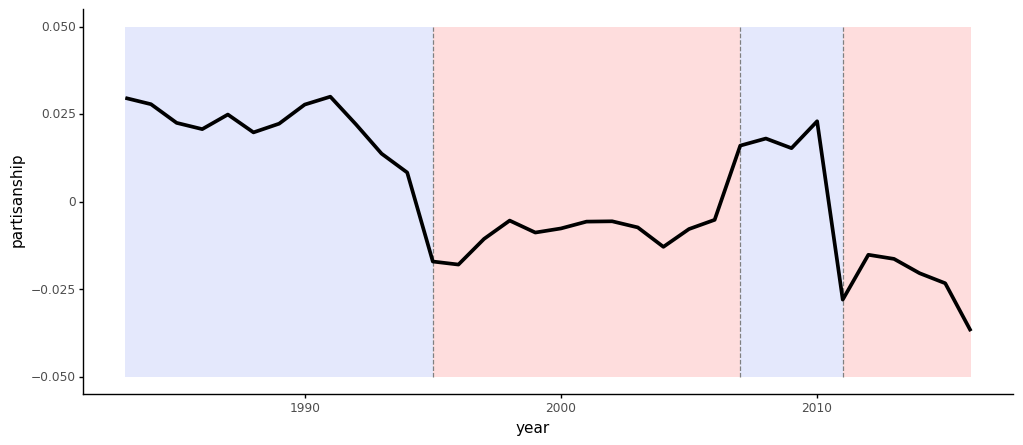

<ggplot: (8782161282295)>

In [104]:
r = result_DF.groupby('year',as_index=False).partisanship.median()

(
    ggplot(r, aes(x= 'year',y='partisanship')) + 
    geoms.geom_line() +
    annotate('rect',xmin=1983,xmax=1995,ymin=-0.05,ymax=0.05,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=-0.05,ymax=0.05,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=-0.05,ymax=0.05,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=-0.05,ymax=0.05,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=-0.05,yend=0.05,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=-0.05,yend=0.05,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=-0.05,yend=0.05,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5))
)


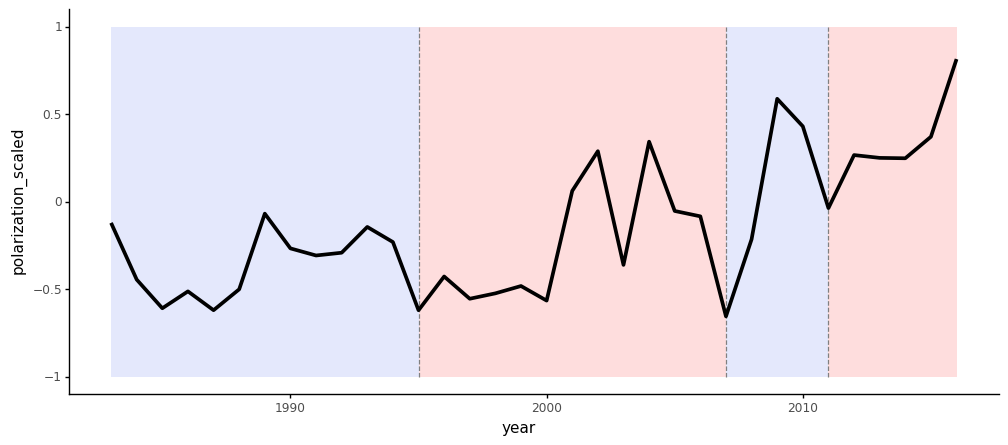

<ggplot: (8782334499575)>

In [105]:
r = result_DF.groupby('year',as_index=False).polarization_scaled.median()

(
    ggplot(r, aes(x= 'year',y='polarization_scaled')) + 
    geoms.geom_line() +
    annotate('rect',xmin=1983,xmax=1995,ymin=-1,ymax=1,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=-1,ymax=1,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=-1,ymax=1,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=-1,ymax=1,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=-1,yend=1,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=-1,yend=1,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=-1,yend=1,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5))
)